In [1]:
import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set()

from sklearn.model_selection import cross_val_score

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import VotingRegressor, StackingRegressor

import pickle
import math
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
import os
import joblib

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

x = pd.read_excel('../data/final_train.xlsx')
y = pd.read_excel('../data/y_train.xlsx')

x.drop(columns = 'ID', inplace= True)
y.drop(columns = 'ID', inplace= True)


np.set_printoptions(formatter={'float_kind':'{:f}'.format})

X_train, X_test, y_train, y_test = train_test_split(x.fillna(0), y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(5600, 171) (1400, 171)
(5600, 1) (1400, 1)


# Finalise Optimised Models in Dictionary

In [4]:
master_models = {}
# Linear Reg -------------
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
master_models['Linear Regression'] = lin_reg
# Lasso Reg -------------
lasso =  make_pipeline(StandardScaler(),
                        Lasso(random_state= 42, alpha=20))
lasso.fit(X_train, y_train)
master_models['Lasso'] = lasso
# Ridge Reg -------------
ridge = make_pipeline(StandardScaler(), 
                           Ridge(random_state= 42, alpha = 50))
ridge.fit(X_train, y_train)
master_models['Ridge'] = ridge
# Elastic Net -------------
elastic = make_pipeline(StandardScaler(), 
                             ElasticNet(random_state= 42, alpha=0.01, l1_ratio = 0.5))
elastic.fit(X_train, y_train)
master_models['Elastic Net'] = elastic
# KNN -------------
knn = make_pipeline(StandardScaler(),
                         KNeighborsRegressor(n_neighbors=7))
knn.fit(X_train, y_train)
master_models['KNN'] = knn
# SVR -------------
svr = make_pipeline(StandardScaler(),
                         SVR(kernel='rbf', C=2000, gamma=0.001))
svr.fit(X_train, y_train)
master_models['SVR'] = svr
# Decision Tree -------------
dt = DecisionTreeRegressor(max_depth=6, max_features='auto', min_samples_leaf=4, random_state=42)
dt.fit(X_train, y_train)
master_models['Decision Tree'] = dt
# Random Forest -------------
rf = RandomForestRegressor(max_depth=7, max_features=20, n_estimators=1200, random_state=42)
rf.fit(X_train, y_train)
master_models['Random Forest'] = rf
# XGBOOST -------------
xgb = XGBRegressor(max_depth=5, n_estimators=300, random_state=42, learning_rate = 0.1, min_child_weight = 1)
xgb.fit(X_train, y_train)
master_models['XGBoost'] = xgb
# GBM ------------------
gbm = GradientBoostingRegressor(alpha = 0.5, learning_rate=0.1, max_depth=4, n_estimators=100)
gbm.fit(X_train, y_train)
master_models['GBM'] = gbm
# Light GBM ------------------
# lgbm = LGBMRegressor(learning_rate=0.1, max_depth=5)
# lgbm.fit(X_train, y_train)
# master_models['Light GBM'] = lgbm
mlp = make_pipeline(StandardScaler(),
                    MLPRegressor(alpha=0.05, hidden_layer_sizes=(20,),max_iter=500, random_state=1))
mlp.fit(X_train, y_train)
master_models['MLP'] = mlp


In [19]:
ensembles = {}

In [18]:
# STACK ALL
estimators = [ ('knn', knn), ('gb', gbm),('xgb_regressor', xgb),('random_forest', rf), 
              ('decision_tree',dt),('ridge',ridge),('lasso',lasso),('elasticnet',elastic),
              ('svr',svr),('mlp',mlp),('linear',lin_reg)]
stack_lr_all = StackingRegressor(estimators=estimators, 
                                 final_estimator= lin_reg, 
                                 cv=5, n_jobs= -1, passthrough = False)
stack_lr_all.fit(X_train, y_train)
ensembles['Stack All'] = stack_lr_all

/Users/domnasrabadi/opt/anaconda3/envs/S1_2023/lib/python3.9/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/domnasrabadi/opt/anaconda3/envs/S1_2023/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/domnasrabadi/opt/anaconda3/envs/S1_2023/lib/python3.9/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/domnasrabadi/opt/anaconda3/envs/S1_2023/lib/python3.9/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be

StackingRegressor(cv=5,
                  estimators=[('knn',
                               Pipeline(steps=[('standardscaler',
                                                StandardScaler()),
                                               ('kneighborsregressor',
                                                KNeighborsRegressor(n_neighbors=7))])),
                              ('gb',
                               GradientBoostingRegressor(alpha=0.5,
                                                         max_depth=4)),
                              ('xgb_regressor',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=No...
                                                ElasticNet(alpha=0.01,
                                                           random_state=42))])),
                              ('svr',
                               Pipeline(steps=[('standardscaler',
                                                StandardScaler()),
                                               ('svr',
                                                SVR(C=2000, gamma=0.001))])),
                              ('mlp',
                               Pipeline(steps=[('standardscaler',
                                                StandardScaler()),
                                               ('mlpregressor',
                                                MLPRegressor(alpha=0.05,
                                                             hidden_layer_sizes=(20,),
                                                             max_iter=500,
                                                             random_state=1))])),
                              ('linear', LinearRegression())],
                  final_estimator=LinearRegression(), n_jobs=-1)

In [20]:
# TOP 5
estimators2 = [ ('Random Forest', rf), ('gbm', gbm),('xgb_regressor', xgb),('mlp', mlp), ('decision tree', dt)]
stack_lr_top = StackingRegressor(estimators=estimators2, 
                                 final_estimator= lin_reg, 
                                 cv=5, n_jobs= -1, passthrough = False)
stack_lr_top.fit(X_train, y_train)
ensembles['Stack Top 5'] = stack_lr_top

/Users/domnasrabadi/opt/anaconda3/envs/S1_2023/lib/python3.9/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/domnasrabadi/opt/anaconda3/envs/S1_2023/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/domnasrabadi/opt/anaconda3/envs/S1_2023/lib/python3.9/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/domnasrabadi/opt/anaconda3/envs/S1_2023/lib/python3.9/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be

In [21]:
vote_all = VotingRegressor(estimators=estimators)
vote_all.fit(X_train, y_train)
ensembles['Voting All'] = vote_all

vote_top5 = VotingRegressor(estimators=estimators2)
vote_top5.fit(X_train, y_train)
ensembles['Voting Top 5'] = vote_top5

# Dump and Load all Tuned Models

In [22]:
joblib.dump(master_models['Linear Regression'], '../pickled_models/linreg1.pkl')
joblib.dump(master_models['Lasso'], '../pickled_models/lasso1.pkl')
joblib.dump(master_models['Ridge'], '../pickled_models/ridge1.pkl')
joblib.dump(master_models['Elastic Net'], '../pickled_models/elasticnet1.pkl')
joblib.dump(master_models['KNN'], '../pickled_models/knn1.pkl')
joblib.dump(master_models['SVR'], '../pickled_models/svr1.pkl')
joblib.dump(master_models['Decision Tree'], '../pickled_models/dt1.pkl')
joblib.dump(master_models['Random Forest'], '../pickled_models/rf1.pkl')
joblib.dump(master_models['XGBoost'], '../pickled_models/xgb1.pkl')
joblib.dump(master_models['GBM'], '../pickled_models/gbm1.pkl')
joblib.dump(master_models['MLP'], '../pickled_models/mlp1.pkl')

joblib.dump(ensembles['Stack All'], '../pickled_models/stack_lr_all.pkl')
joblib.dump(ensembles['Stack Top 5'], '../pickled_models/stack_top_5.pkl')
joblib.dump(ensembles['Voting All'], '../pickled_models/voting_all.pkl')
joblib.dump(ensembles['Voting Top 5'], '../pickled_models/voting_top_5.pkl')

['../pickled_models/voting_top_5.pkl']

# Evaluate All Models

In [23]:
model_names = []
train_mae = []
train_mse = []
train_rmse = []
train_r2 = []
test_mae = []
test_mse = []
test_rmse = []
test_r2 = []

for i in master_models.items():
    model_names.append(i[0])
    train_preds = i[1].predict(X_train)
    test_preds = i[1].predict(X_test)
    mean_absolute_error
    train_mae.append(mean_absolute_error(y_train, train_preds))
    train_mse.append(mean_squared_error(y_train, train_preds))
    train_rmse.append(math.sqrt(mean_squared_error(y_train, train_preds)))
    train_r2.append(r2_score(y_train, train_preds))
    test_mae.append(mean_absolute_error(y_test, test_preds))
    test_mse.append(mean_squared_error(y_test, test_preds))
    test_rmse.append(math.sqrt(mean_squared_error(y_test, test_preds)))
    test_r2.append(r2_score(y_test, test_preds))

single_df = pd.DataFrame({
    'Model':model_names,
    'Train MAE':train_mae,
    'Train MSE':train_mse,
    'Train RMSE':train_rmse,
    'Train R2':train_r2,
    'Test MAE':test_mae,
    'Test MSE':test_mse,
    'Test RMSE':test_rmse,
    'Test R2':test_r2
})

In [24]:
model_names = []
train_mae = []
train_mse = []
train_rmse = []
train_r2 = []
test_mae = []
test_mse = []
test_rmse = []
test_r2 = []

for i in ensembles.items():
    model_names.append(i[0])
    train_preds = i[1].predict(X_train)
    test_preds = i[1].predict(X_test)
    mean_absolute_error
    train_mae.append(mean_absolute_error(y_train, train_preds))
    train_mse.append(mean_squared_error(y_train, train_preds))
    train_rmse.append(math.sqrt(mean_squared_error(y_train, train_preds)))
    train_r2.append(r2_score(y_train, train_preds))
    test_mae.append(mean_absolute_error(y_test, test_preds))
    test_mse.append(mean_squared_error(y_test, test_preds))
    test_rmse.append(math.sqrt(mean_squared_error(y_test, test_preds)))
    test_r2.append(r2_score(y_test, test_preds))

ensemble_df = pd.DataFrame({
    'Model':model_names,
    'Train MAE':train_mae,
    'Train MSE':train_mse,
    'Train RMSE':train_rmse,
    'Train R2':train_r2,
    'Test MAE':test_mae,
    'Test MSE':test_mse,
    'Test RMSE':test_rmse,
    'Test R2':test_r2
})

In [31]:
df = pd.concat([single_df, ensemble_df]).reset_index().drop(columns=['index']).round(2)
df

,Model,Train MAE,Train MSE,Train RMSE,Train R2,Test MAE,Test MSE,Test RMSE,Test R2
0,Linear Regression,122.31,44151.44,210.12,0.62,127.76,45125.23,212.43,0.60
1,Lasso,118.11,52413.80,228.94,0.55,122.53,51467.71,226.86,0.54
2,Ridge,121.45,44349.84,210.59,0.62,126.58,45108.64,212.39,0.60
3,Elastic Net,121.66,44286.14,210.44,0.62,126.85,45082.53,212.33,0.60
4,KNN,92.62,38310.76,195.73,0.67,109.12,50655.77,225.07,0.55
5,SVR,64.33,33667.31,183.49,0.71,88.28,37771.45,194.35,0.66
6,Decision Tree,89.96,29580.33,171.99,0.74,108.02,49359.53,222.17,0.56
7,Random Forest,83.75,21873.13,147.90,0.81,99.54,39450.59,198.62,0.65
8,XGBoost,37.73,3410.31,58.40,0.97,87.60,32339.47,179.83,0.71
9,GBM,63.70,11335.11,106.47,0.90,89.07,31544.11,177.61,0.72


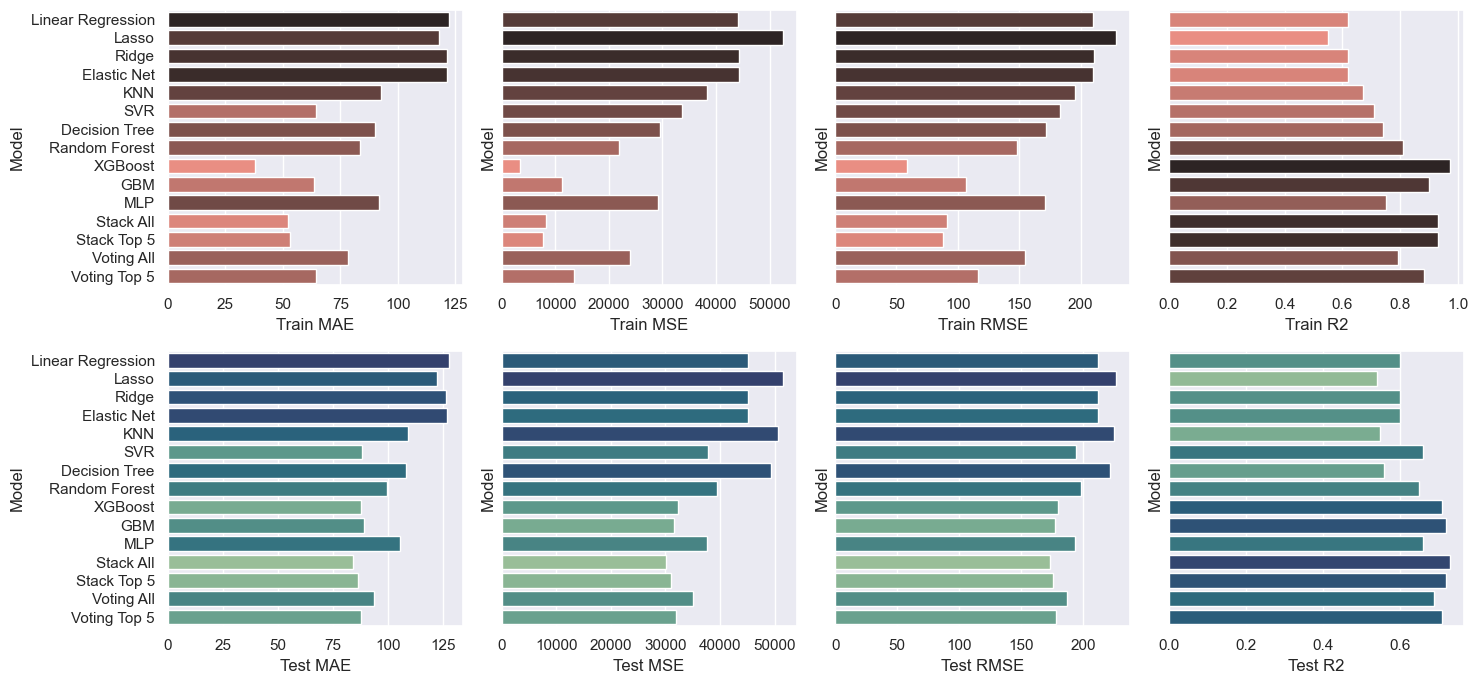

In [95]:
fig, axes = plt.subplots(2, 4, figsize=(15, 7), sharey=True)
axes = axes.flatten()

sns.barplot(data=df, y = 'Model', x = 'Train MAE', palette= 'dark:salmon_r', hue = 'Train MAE', dodge=False, ax=axes[0])
sns.barplot(data=df, y = 'Model', x = 'Train MSE', palette= 'dark:salmon_r', hue = 'Train MSE', dodge=False, ax=axes[1])
sns.barplot(data=df, y = 'Model', x = 'Train RMSE', palette= 'dark:salmon_r', hue = 'Train RMSE', dodge=False, ax=axes[2])
sns.barplot(data=df, y = 'Model', x = 'Train R2', palette= 'dark:salmon_r', hue = 'Train R2', dodge=False, ax=axes[3])
sns.barplot(data=df, y = 'Model', x = 'Test MAE', palette= 'crest', hue = 'Test MAE', dodge=False, ax=axes[4])
sns.barplot(data=df, y = 'Model', x = 'Test MSE', palette= 'crest', hue = 'Test MSE', dodge=False, ax=axes[5])
sns.barplot(data=df, y = 'Model', x = 'Test RMSE', palette= 'crest', hue = 'Test RMSE', dodge=False, ax=axes[6])
sns.barplot(data=df, y = 'Model', x = 'Test R2', palette= 'crest', hue = 'Test R2', dodge=False, ax=axes[7])

for i in range(8):
    axes[i].get_legend().remove()
fig.tight_layout()
plt.show()